# TP N°5: Ensemebles de modèles

Dans ce TP nous allons voir comment combiner des modèles pour améliorer les performances de prédiction.


## A compléter ici :
### Nom : Andrieu
### Prénom : Ludovic
### N étudiant : 22103219

## Bagging (Bootstrap Aggregating)

Le **Bagging** (Bootstrap Aggregating) est une méthode d'**apprentissage d'ensemble** qui vise à améliorer la précision et la robustesse des modèles en combinant plusieurs estimateurs entraînés indépendamment. 

### Principe du Bagging

Le Bagging repose sur les étapes suivantes :

1. **Génération de plusieurs échantillons bootstrap**  
   - À partir du jeu de données d'entraînement, on génère plusieurs sous-échantillons en tirant aléatoirement avec remise.
   
2. **Entraînement de plusieurs modèles**  
   - Un même modèle de base (ex. : arbre de décision, régression) est entraîné sur chaque sous-échantillon.

3. **Agrégation des prédictions**  
   - Pour une tâche de classification : on effectue un **vote majoritaire** entre les modèles.  
   - Pour une tâche de régression : on prend la **moyenne** des prédictions.

### Avantages du Bagging

- **Réduction de la variance** : en combinant plusieurs modèles, le Bagging permet de stabiliser les prédictions et d'éviter le surapprentissage.  
- **Robustesse aux perturbations** : les modèles individuels étant entraînés sur des échantillons différents, ils sont moins sensibles aux variations du jeu de données.  
- **Parallélisation possible** : chaque modèle étant entraîné indépendamment, le Bagging est facilement parallélisable.  

Une application courante du Bagging est l'algorithme **Random Forest**, qui utilise des arbres de décision comme modèles de base.


# Exercice 1.1 : Implémentation manuelle du Bagging en régression

Dans cet exercice, nous allons implémenter **manuellement** l’algorithme de **Bagging** pour un problème de régression, sans utiliser `BaggingRegressor` de `scikit-learn`. Nous utiliserons un **arbre de décision** comme modèle de base.

## Objectifs de l'exercice

- Comprendre le fonctionnement interne du Bagging appliqué à la régression.  
- Générer des échantillons bootstrap à partir des données d'entraînement.  
- Entraîner plusieurs modèles indépendants sur ces échantillons.  
- Agréger les prédictions des modèles en utilisant la **moyenne** des prédictions.  
- Comparer les performances du modèle simple et du modèle avec Bagging.  

## Consignes

1. **Chargement des données**  
   - Générer un jeu de données de régression (`make_regression` de `sklearn.datasets`).  
   - Séparer les données en un ensemble d’entraînement et un ensemble de test.  

2. **Entraînement d'un modèle de base**  
   - Entraîner un **arbre de décision** (`DecisionTreeRegressor`) sur les données d'entraînement.  
   - Évaluer sa performance sur les données de test avec l'**erreur quadratique moyenne (MSE)**.  

3. **Implémentation manuelle du Bagging**  
   - **Génération des échantillons bootstrap** : créer plusieurs sous-échantillons en tirant aléatoirement avec remise.  
   - **Entraînement de plusieurs modèles** : entraîner un **arbre de décision** sur chaque sous-échantillon.  
   - **Agrégation des prédictions** : prendre la **moyenne des prédictions** des modèles entraînés.  

4. **Comparaison des résultats**  
   - Comparer la performance du modèle unique et du modèle avec Bagging.  
   - Comparer la performance en fonction de nombre de sous-modèles (en utilisant matplotlib).

## Indications

- Utiliser `train_test_split` de `sklearn.model_selection` pour diviser les données.  
- Pour créer les échantillons bootstrap, utiliser `np.random.choice` avec `replace=True`.  
- Pour évaluer les modèles, utiliser `mean_squared_error` où `mean_absolute_error` de `sklearn.metrics`.  
- Tester différents nombres d’estimateurs (`n_estimators`) pour observer l’impact du Bagging.  


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

X, y, *_ = make_regression(n_samples=1000, n_features=20, n_informative=10, noise=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(len(X_train), len(X_test))

Matplotlib is building the font cache; this may take a moment.


700 300


In [3]:


class MyBaggingRegressor():
    def __init__(self, model:DecisionTreeRegressor, nbSubModels:int) -> None:
        assert model.get_params(deep=False)["criterion"] in ("squared_error", "absolute_error", )
        self.allModels: list[DecisionTreeRegressor] = [
            DecisionTreeRegressor().set_params(**model.get_params()) 
            for _ in range(nbSubModels)]
    @property
    def nbSubModels(self)->int: 
        return len(self.allModels)
    
    def fit(self, X:np.ndarray, y:np.ndarray)->None:
        for modelIndex, model in enumerate(self.allModels):
            model.fit(*self._createSubSamples(
                self._preprocessDatas(X, modelIndex), y))

    def predict(self, X:np.ndarray)->np.ndarray:
        y_sum = np.zeros((len(X), ))
        for modelIndex in range(self.nbSubModels):
            y_sum += self.predict_model(X, modelIndex=modelIndex)
        return (y_sum / self.nbSubModels)
    
    def predict_model(self, X:np.ndarray, modelIndex:int)->np.ndarray:
        return self.allModels[modelIndex].predict(self._preprocessDatas(X, modelIndex))

    def _preprocessDatas(self, X:np.ndarray, modelIndex:int)->np.ndarray:
        return X

    def _createSubSamples(self, X:np.ndarray, y:np.ndarray)->tuple[np.ndarray, np.ndarray]:
        N = len(y)
        subIndexes = np.random.randint(0, N, size=(N, ))
        return (X[subIndexes], y[subIndexes])


    def evaluate(self, X:np.ndarray, y_true:np.ndarray)->float:
        loss = mean_squared_error(y_true, self.predict(X))
        return float(loss) # should be from a np.float64

In [4]:
myBagg = MyBaggingRegressor(model=DecisionTreeRegressor(), nbSubModels=100)
myBagg.fit(X_train, y_train)
print(f"train loss = {myBagg.evaluate(X_train, y_train):.3f}")
print(f"test loss = {myBagg.evaluate(X_test, y_test):.3f}")

train loss = 1196.347
test loss = 7322.064


# Exercise 1.2

- Faire la meme chose en utilisant `BaggingRegressor`

In [5]:
from sklearn.ensemble import BaggingRegressor

from sklearn.model_selection import cross_val_score
baseModel = DecisionTreeRegressor()
baggModel = BaggingRegressor(baseModel, n_estimators=100, n_jobs=5)

baggModel.fit(X_train, y_train)
y_train_pred = baggModel.predict(X_train)
y_test_pred = baggModel.predict(X_test)

print(f"train loss = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"test loss = {mean_squared_error(y_test, y_test_pred):.3f}")
print()

base_cv_scores = -1 * cross_val_score(baseModel, X, y, cv=5, n_jobs=5, scoring="neg_mean_squared_error")
bagg_cv_scores = -1 * cross_val_score(baggModel, X, y, cv=5, n_jobs=5, scoring="neg_mean_squared_error")
print(f"base mse: {base_cv_scores.mean():.3f} +/- {base_cv_scores.std():.3f}")
print(f"bagg mse: {bagg_cv_scores.mean():.3f} +/- {bagg_cv_scores.std():.3f}")

train loss = 1173.439
test loss = 7336.207

base mse: 20083.367 +/- 1839.782
bagg mse: 8354.688 +/- 1069.676


# Exercice 2 : Implémentation des forêts aléatoires

Dans cet exercice, nous allons explorer **les forêts aléatoires**, une amélioration du Bagging qui introduit une **sélection aléatoire des caractéristiques** à chaque division de l’arbre. Nous commencerons par une **implémentation manuelle**, avant d'utiliser `RandomForestRegressor` de `scikit-learn`.

## Objectifs de l'exercice

- Comprendre la différence entre le Bagging et les forêts aléatoires.  
- Implémenter une forêt aléatoire manuellement en modifiant le Bagging.  
- Observer l'impact de la sélection aléatoire des caractéristiques sur la performance du modèle.  
- Comparer les résultats entre l'implémentation manuelle et `RandomForestRegressor`.

## Exercice 2.1 : Implémentation manuelle des forêts aléatoires

### Consignes

1. **Chargement des données**  
   - Utiliser `make_regression` de `sklearn.datasets` pour générer un problème de régression.  
   - Séparer les données en un ensemble d’entraînement et un ensemble de test.  

2. **Implémentation manuelle des forêts aléatoires**  
   - Reprendre le code du **Bagging manuel** de l'exercice précédent.  
   - Modifier l’entraînement des modèles pour que chaque **arbre de décision sélectionne un sous-ensemble aléatoire de features** à chaque division. Pour les selectionner, vous 
   - Tester différents nombres de variables sélectionnées (`max_features`).  

3. **Évaluation et comparaison**  
   - Comparer la performance du modèle avec et sans sélection aléatoire des features. 

### Indications

- Pour choisir les features à utiliser pour chaque modèle vous pouver utiliser `np.random.choice` sur `X_train.shape[1]`
- Tester différentes valeurs de `max_features` (ex. : `sqrt(n_features)`, `log2(n_features)`, ou un nombre fixe).  
- Évaluer la performance avec `mean_squared_error`.  

In [6]:
from sklearn.tree import DecisionTreeRegressor
from typing_extensions import Literal, override

_MaxFeaturesKind = Literal["sqrt", "log2"]

class MyRandomForestRegressor(MyBaggingRegressor):
    def __init__(self, model: DecisionTreeRegressor, nbSubModels: int,
                 datasNbFeatures:int, maxFeatures:int|_MaxFeaturesKind, minFeatures:int) -> None:
        assert minFeatures >= 1, f"can't train a model on {minFeatures} features"
        super().__init__(model, nbSubModels)
        self.datasNbFeatures: int = datasNbFeatures
        self.maxFeatures:int|_MaxFeaturesKind = maxFeatures
        self.minFeatures:int = minFeatures
        self.perModelsFeatures: list[np.ndarray] = []
        for index in range(self.nbSubModels):
            self.perModelsFeatures.append(self._decideSubFeatures())
    
    def _getMaxFeatures(self, nbFeatures: int)->int:
        maxFeatures: int
        if self.maxFeatures == "sqrt":
            maxFeatures = int(np.ceil(np.sqrt(nbFeatures)))
        elif self.maxFeatures == "log2":
            maxFeatures = int(np.ceil(np.log2(nbFeatures)))
        else: # => self.maxFeatures is an int
            maxFeatures = int(self.maxFeatures)
        assert maxFeatures >= 1, f"can't train a model on {maxFeatures} features"
        assert maxFeatures <= maxFeatures, f"the datas dont have enougth features ({maxFeatures} > {nbFeatures})"
        return maxFeatures
    
    def _decideSubFeatures(self):
        nbSubFeatures: int = np.random.randint(
            self.minFeatures, self._getMaxFeatures(self.datasNbFeatures)+1)
        nbFeatures: int = X.shape[1]
        subFeaturesIndexes = np.arange(nbFeatures)
        np.random.shuffle(subFeaturesIndexes)
        subFeaturesIndexes = subFeaturesIndexes[: nbSubFeatures]
        return subFeaturesIndexes
    
    @override
    def _preprocessDatas(self, X:np.ndarray, modelIndex:int)->np.ndarray:
        return X[:, self.perModelsFeatures[modelIndex]]
    

In [7]:
# X, y, *_ = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=10, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# print(len(X_train), len(X_test))

In [8]:
myRandForest = MyRandomForestRegressor(
    model=DecisionTreeRegressor(), nbSubModels=100,
    datasNbFeatures=(X.shape[1]), maxFeatures=15, minFeatures=10)
myRandForest.fit(X_train, y_train)
print("sklearn model")
print(f"train loss = {myRandForest.evaluate(X_train, y_train):.3f}")
print(f"test loss = {myRandForest.evaluate(X_test, y_test):.3f}")

print()
print("my model")
myBagg = MyBaggingRegressor(model=DecisionTreeRegressor(), nbSubModels=100)
myBagg.fit(X_train, y_train)
print(f"train loss = {myBagg.evaluate(X_train, y_train):.3f}")
print(f"test loss = {myBagg.evaluate(X_test, y_test):.3f}")

sklearn model
train loss = 1528.968
test loss = 10329.343

my model
train loss = 1140.441
test loss = 7456.646


## Exercice 2.2 : Utilisation de `RandomForestRegressor`

### Consignes

1. Utiliser `RandomForestRegressor` de `sklearn.ensemble` avec les mêmes données.  
2. Ajuster les paramètres `n_estimators` et `max_features`.  
3. Comparer les performances entre l’implémentation manuelle et `RandomForestRegressor`.  
 


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
baseModel = DecisionTreeRegressor()
randForest = RandomForestRegressor(100, max_features=15)

randForest.fit(X_train, y_train)
y_train_pred = randForest.predict(X_train)
y_test_pred = randForest.predict(X_test)

print(f"train loss = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"test loss = {mean_squared_error(y_test, y_test_pred):.3f}")
print()

base_cv_scores = -1 * cross_val_score(baseModel, X, y, cv=5, n_jobs=5, scoring="neg_mean_squared_error")
forest_cv_scores = -1 * cross_val_score(randForest, X, y, cv=5, n_jobs=5, scoring="neg_mean_squared_error")
print(f"base mse: {base_cv_scores.mean():.3f} +/- {base_cv_scores.std():.3f}")
print(f"bagg mse: {forest_cv_scores.mean():.3f} +/- {forest_cv_scores.std():.3f}")

# les performance de MyRandomForestRegressor sont bien en dessous de celles de sklearn
# probablement duent a la selection des features 

train loss = 1171.860
test loss = 7303.203

base mse: 20257.571 +/- 2217.437
bagg mse: 8427.153 +/- 1061.554


# Exercice 3.1 : AdaBoost

L'**AdaBoost** (Adaptive Boosting) est une méthode d'ensemble qui combine plusieurs modèles faibles (souvent des arbres de décision peu profonds) pour créer un modèle puissant. Le principe de base est de **donner plus de poids aux erreurs** faites par les premiers modèles et de corriger ces erreurs dans les modèles suivants. Chaque modèle successif est entraîné sur les exemples mal classés du modèle précédent.

## Objectifs de l'exercice

1. Entraîner un modèle AdaBoost en régression avec `AdaBoostRegressor`.
2. Comparer les performances d'un **modèle de base** (par exemple, un arbre de décision) et du modèle **AdaBoost**.

### Consignes

1. **Chargement des données**
   - Utilisez `make_regression` pour générer un jeu de données de régression.
   - Divisez les données en ensemble d’entraînement et ensemble de test.

2. **Modèle de base : Arbre de décision**
   - Entraînez un modèle de base (par exemple un arbre de décision) et évaluez sa performance sur les données de test avec **l'erreur quadratique moyenne (MSE)**.

3. **Utilisation d'AdaBoostRegressor**
   - Utilisez `AdaBoostRegressor` de `scikit-learn` pour entraîner un modèle AdaBoost sur les données.
   - Comparez les performances du modèle AdaBoost avec celles du modèle de base.

4. **Analyse des résultats**
   - Que se passe-t-il si vous changez la profondeur maximale d'arbres utilisés?
   - Que se passe-t-il si vous changez le nombre d'estimateurs dans `AdaBoostRegressor` ?

### Indications

- Utilisez `AdaBoostRegressor` de `sklearn.ensemble`.
- Pour comparer les performances, utilisez `mean_squared_error` de `sklearn.metrics`.


In [33]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
baseModel_ada = DecisionTreeRegressor()
adaModel = AdaBoostRegressor(baseModel_ada, n_estimators=100)

adaModel.fit(X_train, y_train)
y_train_pred = adaModel.predict(X_train)
y_test_pred = adaModel.predict(X_test)

print(f"train loss = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"test loss = {mean_squared_error(y_test, y_test_pred):.3f}")
print()

base_cv_scores = -1 * cross_val_score(baseModel_ada, X, y, cv=5, n_jobs=5, scoring="neg_mean_squared_error")
ada_cv_scores = -1 * cross_val_score(adaModel, X, y, cv=5, n_jobs=5, scoring="neg_mean_squared_error")
print(f"base mse: {base_cv_scores.mean():.3f} +/- {base_cv_scores.std():.3f}")
print(f"ada mse: {ada_cv_scores.mean():.3f} +/- {ada_cv_scores.std():.3f}")

train loss = 0.318
test loss = 6411.306

base mse: 20463.418 +/- 2700.162
ada mse: 7573.067 +/- 1050.120


# Exercice 3.2 : Gradient Boosting

Le **Gradient Boosting** est une autre méthode d'ensemble basée sur l'optimisation d'un modèle prédictif, mais contrairement à l'AdaBoost, il ajuste les erreurs par **gradient de la fonction de coût**. Chaque modèle successif essaie de corriger l’erreur du modèle précédent, en se concentrant sur les résidus. Le Gradient Boosting est particulièrement puissant et largement utilisé dans des tâches complexes comme la régression et la classification.

## Objectifs de l'exercice

1. Entraîner un modèle de **Gradient Boosting** avec `GradientBoostingRegressor`.
2. Comparer les performances du **modèle de base** (arbre de décision) et du modèle **Gradient Boosting**.

### Consignes

1. **Chargement des données**
   - Utilisez `make_regression` pour générer un jeu de données de régression.
   - Divisez les données en un ensemble d’entraînement et un ensemble de test.

2. **Modèle de base : Arbre de décision**
   - Entraînez un modèle de base (par exemple, un arbre de décision) et évaluez sa performance sur les données de test avec **l'erreur quadratique moyenne (MSE)**.

3. **Utilisation de GradientBoostingRegressor**
   - Utilisez `GradientBoostingRegressor` de `scikit-learn` pour entraîner un modèle Gradient Boosting sur les données.
   - Comparez les performances du modèle Gradient Boosting avec celles du modèle de base.

4. **Analyse des résultats**
   - Que se passe-t-il si vous changez la profondeur maximale d'arbres utilisés? Visualisez la dépendance.
   - Que se passe-t-il si vous changez le nombre d'arbres (`n_estimators`) dans `GradientBoostingRegressor` ?
   - Comparez la vitesse de convergence d'erreur entre AdaBoost et Gradient boosting (visuellement).

### Indications

- Utilisez `GradientBoostingRegressor` de `sklearn.ensemble`.
- Pour comparer les performances, utilisez `mean_squared_error` de `sklearn.metrics`.


In [34]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
GBModel = GradientBoostingRegressor(n_estimators=100, max_depth=3)

GBModel.fit(X_train, y_train)
y_train_pred = GBModel.predict(X_train)
y_test_pred = GBModel.predict(X_test)

print(f"train loss = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"test loss = {mean_squared_error(y_test, y_test_pred):.3f}")
print()

ada_cv_scores = -1 * cross_val_score(adaModel, X, y, cv=5, n_jobs=5, scoring="neg_mean_squared_error")
gb_cv_scores = -1 * cross_val_score(GBModel, X, y, cv=5, n_jobs=5, scoring="neg_mean_squared_error")
print(f"ada mse: {ada_cv_scores.mean():.3f} +/- {ada_cv_scores.std():.3f}")
print(f"GB mse: {gb_cv_scores.mean():.3f} +/- {gb_cv_scores.std():.3f}")

train loss = 453.697
test loss = 3223.681

ada mse: 7459.951 +/- 1051.675
GB mse: 3486.111 +/- 468.653


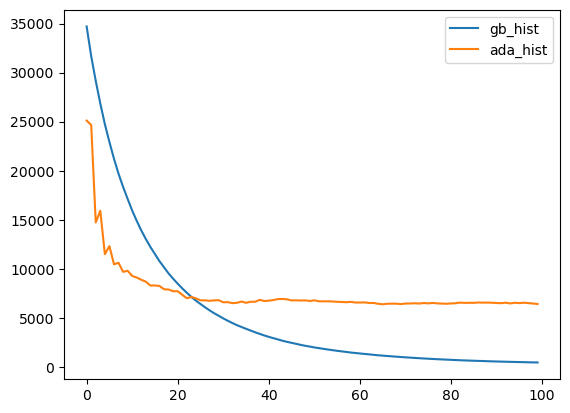

In [ ]:
gb_hist = GBModel.train_score_
ada_hist = [mean_squared_error(y_test, y_pred) 
            for y_pred in adaModel.staged_predict(X_test)]
#print(gb_hist)
#print(ada_hist)
plt.plot(gb_hist, label="gb_hist")
plt.plot(ada_hist, label="ada_hist")
plt.legend()

In [16]:
GBModel = GradientBoostingRegressor(n_estimators=100, max_depth=5)

GBModel.fit(X_train, y_train)
y_train_pred = GBModel.predict(X_train)
y_test_pred = GBModel.predict(X_test)

print(f"train loss = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"test loss = {mean_squared_error(y_test, y_test_pred):.3f}")
print()

gb_cv_scores = -1 * cross_val_score(GBModel, X, y, cv=5, n_jobs=5, scoring="neg_mean_squared_error")
print(f"GB mse: {gb_cv_scores.mean():.3f} +/- {gb_cv_scores.std():.3f}")

train loss = 47.151
test loss = 3938.543

GB mse: 4514.827 +/- 792.815


In [17]:
GBModel = GradientBoostingRegressor(n_estimators=100, max_depth=15)

GBModel.fit(X_train, y_train)
y_train_pred = GBModel.predict(X_train)
y_test_pred = GBModel.predict(X_test)

print(f"train loss = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"test loss = {mean_squared_error(y_test, y_test_pred):.3f}")
print()

gb_cv_scores = -1 * cross_val_score(GBModel, X, y, cv=5, n_jobs=5, scoring="neg_mean_squared_error")
print(f"GB mse: {gb_cv_scores.mean():.3f} +/- {gb_cv_scores.std():.3f}")

train loss = 0.000
test loss = 20040.855

GB mse: 18404.607 +/- 1963.957


In [14]:
# max_depth augmente la tendence a overfit, ce qui réduit grandement les perfs sur les tests

In [18]:
GBModel = GradientBoostingRegressor(n_estimators=10, max_depth=3)

GBModel.fit(X_train, y_train)
y_train_pred = GBModel.predict(X_train)
y_test_pred = GBModel.predict(X_test)

print(f"train loss = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"test loss = {mean_squared_error(y_test, y_test_pred):.3f}")
print()

gb_cv_scores = -1 * cross_val_score(GBModel, X, y, cv=5, n_jobs=5, scoring="neg_mean_squared_error")
print(f"GB mse: {gb_cv_scores.mean():.3f} +/- {gb_cv_scores.std():.3f}")

train loss = 17128.939
test loss = 20269.475

GB mse: 20810.167 +/- 1293.157


In [20]:
GBModel = GradientBoostingRegressor(n_estimators=300, max_depth=3)

GBModel.fit(X_train, y_train)
y_train_pred = GBModel.predict(X_train)
y_test_pred = GBModel.predict(X_test)

print(f"train loss = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"test loss = {mean_squared_error(y_test, y_test_pred):.3f}")
print()

gb_cv_scores = -1 * cross_val_score(GBModel, X, y, cv=5, n_jobs=5, scoring="neg_mean_squared_error")
print(f"GB mse: {gb_cv_scores.mean():.3f} +/- {gb_cv_scores.std():.3f}")

train loss = 76.179
test loss = 2442.422

GB mse: 2518.169 +/- 303.590


In [ ]:
# augmenter n_estimators a un impacte positif sur les resultats 
# on diminue aussi la variance mais surtout les erreur (au cout de temps a train et predict + memoire)